In [1]:
import pickle
import numpy as np
import os
import torch
import torch.nn as nn
import re
import sys
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR, STDP_SR, Linear, MLP
from datasets import inputs
import configs

device = 'cpu'

## Plot loss for one-hot features

In [2]:
experiment_dir = "/home/chingf/engram/Ching/03_td_baselines/0.4/"
steps = []
losses = []
models = []

for model in os.listdir(experiment_dir):
    model_dir = experiment_dir + model + '/'
    for _iter in os.listdir(model_dir):
        iter_dir = model_dir + _iter + '/'
        if not os.path.isdir(iter_dir): continue
        for file in os.listdir(iter_dir):
            if 'tfevents' not in file: continue
            tfevents_file = iter_dir + '/' + file
            event_acc = EventAccumulator(tfevents_file)
            event_acc.Reload()
            scalar_events = event_acc.Scalars('loss_train')
            for i in range(len(scalar_events)):
                steps.append(scalar_events[i].step)
                losses.append(scalar_events[i].value)
                models.append(model)

steps = np.array(steps)/(60*configs.dt_to_sec)
losses = np.array(losses)
models = np.array(models)

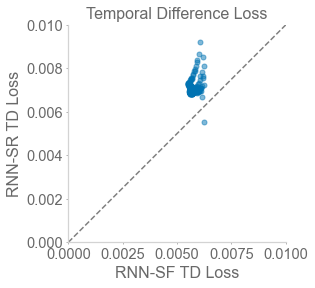

In [3]:
plt.figure()
plt.axes().set_aspect('equal')
plt.scatter(
    losses[models == 'rnn_sf'], losses[models == 'rnn_sr'],
    s=25, alpha=0.5
    )
plt.plot(np.linspace(0, 0.01, 2), np.linspace(0, 0.01, 2), '--', color='gray')
plt.xlim(0.0, 0.01); plt.ylim(0.0, 0.01)
plt.xlabel('RNN-SF TD Loss')
plt.ylabel('RNN-SR TD Loss')
plt.title('Temporal Difference Loss')
plt.savefig('3a_onehot_tdloss_scatter.png', dpi=300)
plt.show()

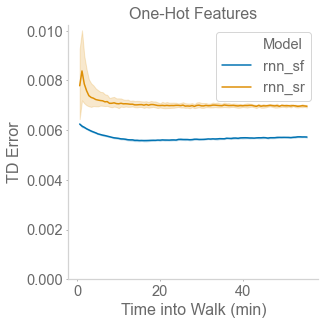

In [6]:
df = pd.DataFrame({'Steps into Walk': steps, 'TD Error': losses, 'Model': models})
fig, ax = plt.subplots(
    figsize=(6.4*0.75, 4.8*1.)
    ) # width, height
sns.lineplot(
    x='Steps into Walk', y='TD Error', data=df, ax=ax, hue='Model'
    )
plt.xlabel('Time into Walk (min)')
plt.ylabel('TD Error')
plt.title('One-Hot Features')
plt.ylim(0)
plt.tight_layout()
plt.savefig('3a_onehot_tdloss.png', dpi=100)
plt.show()

# Look at M/T error

In [23]:
results_dirs = [
    ["RNN-SR", f"{experiment_dir}rnn_sr/results_0.4.p"],
    ["RNN-SF", f"{experiment_dir}rnn_sf/results_0.4.p"]
]

In [27]:
t_errors = []
m_errors = []
t_row_norms = []
times = []
models = []
for model, path in results_dirs:
    with open(path, 'rb') as f:
        results = pickle.load(f)
    t_error = results['T_error']
    m_error = results['M_error']
    t_row_norm = results['T_row_norm']
    t_col_norm = results['T_col_norm']
    
    for _iter in range(len(m_error)):
        _t_error = t_error[_iter]*100
        _time = np.arange(_t_error.size)[::10]/configs.dt_to_sec/60
        t_errors.extend(_t_error[::10])
        m_errors.extend(m_error[_iter][::10]*100)
        t_row_norms.extend(t_row_norm[_iter][::10])
        times.extend(_time)
        models.extend([model]*_time.size)
df = pd.DataFrame({
    't_errors': t_errors, 'm_errors': m_errors,
    't_row_norms': t_row_norms,
    'times': times, 'models':models
    })

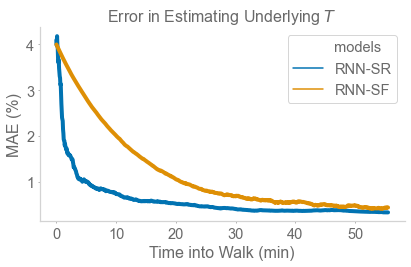

In [29]:
sns.lineplot(x='times', y='t_errors', hue='models', data=df, linewidth=4)
plt.title('Error in Estimating Underlying $T$')
plt.ylabel('MAE (%)')
plt.xlabel('Time into Walk (min)')
plt.tight_layout()
plt.savefig('3a_onehot_T_error.png', dpi=300)
plt.show()

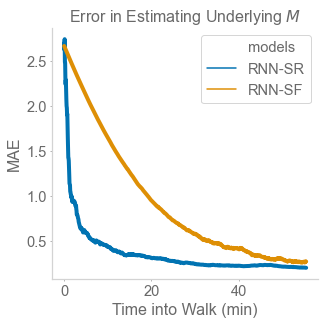

In [68]:
fig, ax = plt.subplots(figsize=(6.4*0.75, 4.8*1.))
sns.lineplot(x='times', y='m_errors', hue='models', data=df, linewidth=4)
plt.title('Error in Estimating Underlying $M$')
plt.ylabel('MAE')
plt.xlabel('Time into Walk (min)')
plt.tight_layout()
plt.savefig('3a_onehot_M_error.png', dpi=300)
plt.show()

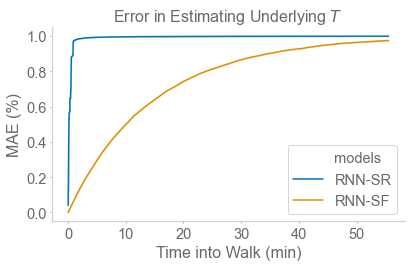

In [8]:
sns.lineplot(x='times', y='t_row_norms', hue='models', data=df, linewidth=4)
plt.title('Time to Probability Normalization')
plt.ylabel('Mean $T$ Row Sum')
plt.xlabel('Time into Walk (min)')
plt.tight_layout()
plt.savefig('3a_onehot_T_rownorm.png', dpi=300)
plt.show()

# Visually compare learned M

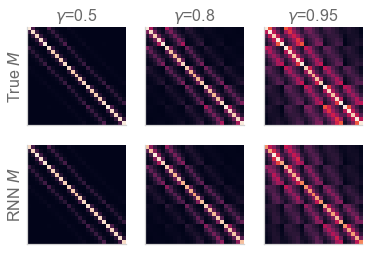

In [64]:
test_gammas = [0.5, 0.8, 0.95]
with open(f"{experiment_dir}rnn_sf/0/results.p", 'rb') as f:
    results = pickle.load(f)
rnn_T = results['rnn_T']
rnn_M = results['rnn_M']
dset = results['dset']
true_T = dset.get_true_T()

fig, axs = plt.subplots(2, 3)
for idx, test_gamma in enumerate(test_gammas):
    true_M = np.linalg.pinv(np.eye(true_T.shape[0]) - test_gamma*true_T)
    rnn_M = np.linalg.pinv(np.eye(true_T.shape[0]) - test_gamma*rnn_T.detach().numpy())
    axs[0,idx].imshow(true_M)
    axs[1,idx].imshow(rnn_M)
    axs[0,idx].set_title(f'$\gamma$={test_gammas[idx]}')
    axs[0, idx].set_xticks([]); axs[0, idx].set_yticks([]);
    axs[1, idx].set_xticks([]); axs[1, idx].set_yticks([]);
axs[0,0].set_ylabel('True $M$')
axs[1,0].set_ylabel('RNN $M$')
plt.savefig('3a_onehot_M_matrices.png', dpi=300)
plt.show()

# Visually compare learned M

In [9]:
test_gamma = 0.8
with open(f"{experiment_dir}rnn_sf/0/results.p", 'rb') as f:
    results = pickle.load(f)
rnn_T = results['rnn_T']
rnn_M = results['rnn_M']
dset = results['dset']
true_T = dset.get_true_T()
true_M = np.linalg.pinv(np.eye(true_T.shape[0]) - test_gamma*true_T)
rnn_M = np.linalg.pinv(np.eye(true_T.shape[0]) - test_gamma*rnn_T.detach().numpy())

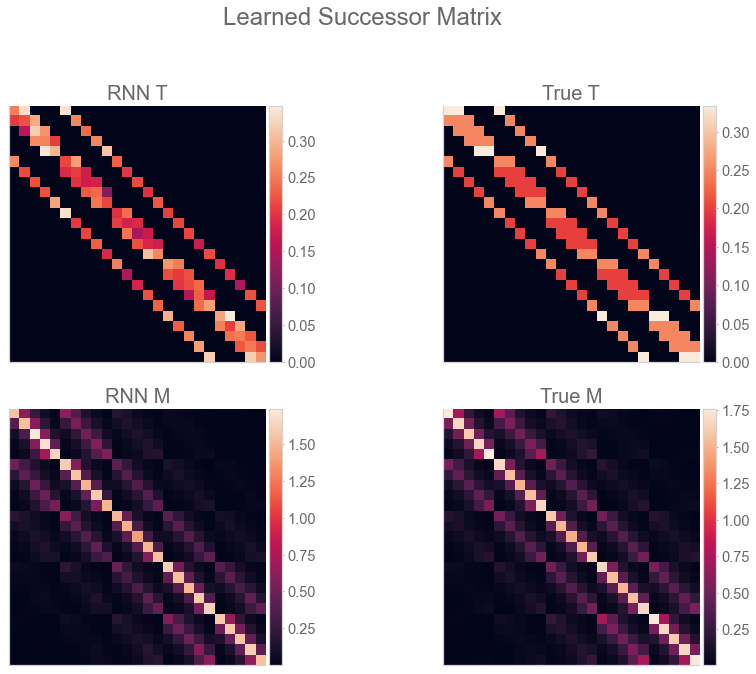

In [10]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axs = plt.subplots(2, 2, figsize=(6.4*2, 4.8*2))
axtitle_fontsize=20

# RNN T
divider = make_axes_locatable(axs[0,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,0].imshow(rnn_T.detach().numpy())
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,0].set_title('RNN T', fontsize=axtitle_fontsize)

# True T
divider = make_axes_locatable(axs[0,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[0,1].imshow(true_T)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[0,1].set_title('True T', fontsize=axtitle_fontsize)

# RNN M
divider = make_axes_locatable(axs[1,0])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,0].imshow(rnn_M)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,0].set_title('RNN M', fontsize=axtitle_fontsize)

# True M
divider = make_axes_locatable(axs[1,1])
cax = divider.append_axes('right', size='5%', pad=0.05)
im = axs[1,1].imshow(true_M)
fig.colorbar(im, cax=cax, orientation='vertical')
axs[1,1].set_title('True M', fontsize=axtitle_fontsize)

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Learned Successor Matrix", fontsize=24)
plt.tight_layout(rect=[0, 0., 1, 0.95])
#plt.savefig('M_comparisons.png', dpi=150)
plt.show()